In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
device = "cuda:7"

In [3]:
import torch
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
from utils import load_image_data, load_image
from typing import Tuple, Union, Optional, List
from tqdm import tqdm
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import torch
from torch.optim.sgd import SGD
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
import numpy as np
from PIL import Image

T = torch.Tensor
TN = Optional[T]
TS = Union[Tuple[T, ...], List[T]]

In [4]:
pipeline = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    safety_checker=None,
).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [5]:


@torch.no_grad()
def get_text_embeddings(pipe: StableDiffusionPipeline, text: str) -> T:
    tokens = pipe.tokenizer(
        [text],
        padding="max_length",
        max_length=77,
        truncation=True,
        return_tensors="pt",
        return_overflowing_tokens=True,
    ).input_ids.to(pipe.device)
    return pipe.text_encoder(tokens).last_hidden_state.detach()


@torch.no_grad()
def denormalize(image):
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).astype(np.uint8)
    return image[0]


@torch.no_grad()
def decode(latent: T, pipe: StableDiffusionPipeline):
    image = pipe.vae.decode((1 / 0.18215) * latent, return_dict=False)[0]
    image = denormalize(image)
    # if im_cat is not None:
    #     image = np.concatenate((im_cat, image), axis=1)
    return Image.fromarray(image)


def display_images(image_list, figsize=(15, 5)):
    """
    显示图像列表，每个图像显示在一排中。

    :param image_list: PIL Image 对象的列表
    :param figsize: 图像的整体显示大小
    """
    n = len(image_list)

    # 创建一个包含 n 个子图的图形
    fig, axes = plt.subplots(1, n, figsize=figsize)

    # 如果只有一个图像，`axes` 会是一个单独的轴，而不是一个数组
    if n == 1:
        axes = [axes]

    for i, img in enumerate(image_list):
        if isinstance(img, Image.Image):  # 确保每个元素是 PIL Image 对象
            axes[i].imshow(img)
            axes[i].axis("off")  # 关闭坐标轴
        else:
            raise ValueError("Each item in the list should be a PIL Image object.")

    plt.tight_layout()  # 自动调整子图间的间距
    plt.show()

In [6]:
def init_pipe(device, dtype, unet, scheduler) -> Tuple[UNet2DConditionModel, T, T]:

    with torch.inference_mode():
        alphas = torch.sqrt(scheduler.alphas_cumprod).to(device, dtype=dtype)
        sigmas = torch.sqrt(1 - scheduler.alphas_cumprod).to(device, dtype=dtype)
    for p in unet.parameters():
        p.requires_grad = False
    return unet, alphas, sigmas


@torch.no_grad()
def denormalize(image):
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).astype(np.uint8)
    return image[0]


class DDSLoss:

    def noise_input(self, z, eps=None, timestep: Optional[int] = None):
        if timestep is None:
            b = z.shape[0]
            timestep = torch.randint(
                low=self.t_min,
                high=min(self.t_max, 1000) - 1,  # Avoid the highest timestep.
                size=(b,),
                device=z.device,
                dtype=torch.long,
            )
        if eps is None:
            eps = torch.randn_like(z)
        alpha_t = self.alphas[timestep, None, None, None]
        sigma_t = self.sigmas[timestep, None, None, None]
        z_t = alpha_t * z + sigma_t * eps
        return z_t, eps, timestep, alpha_t, sigma_t

    def get_eps_prediction(
        self,
        z_t: T,
        timestep: T,
        text_embeddings: T,
        alpha_t: T,
        sigma_t: T,
        get_raw=False,
        guidance_scale=7.5,
    ):

        latent_input = torch.cat([z_t] * 2)
        timestep = torch.cat([timestep] * 2)
        embedd = text_embeddings.permute(1, 0, 2, 3).reshape(
            -1, *text_embeddings.shape[2:]
        )
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            e_t = self.unet(latent_input, timestep, embedd).sample
            if self.prediction_type == "v_prediction":
                e_t = (
                    torch.cat([alpha_t] * 2) * e_t
                    + torch.cat([sigma_t] * 2) * latent_input
                )
            e_t_uncond, e_t = e_t.chunk(2)
            if get_raw:
                return e_t_uncond, e_t
            e_t = e_t_uncond + guidance_scale * (e_t - e_t_uncond)
            assert torch.isfinite(e_t).all()
        if get_raw:
            return e_t
        pred_z0 = (z_t - sigma_t * e_t) / alpha_t
        return e_t, pred_z0

    def get_sds_loss(
        self,
        z: T,
        text_embeddings: T,
        eps: TN = None,
        mask=None,
        t=None,
        timestep: Optional[int] = None,
        guidance_scale=7.5,
    ) -> TS:
        with torch.inference_mode():
            z_t, eps, timestep, alpha_t, sigma_t = self.noise_input(
                z, eps=eps, timestep=timestep
            )
            e_t, _ = self.get_eps_prediction(
                z_t,
                timestep,
                text_embeddings,
                alpha_t,
                sigma_t,
                guidance_scale=guidance_scale,
            )
            grad_z = (alpha_t**self.alpha_exp) * (sigma_t**self.sigma_exp) * (e_t - eps)
            assert torch.isfinite(grad_z).all()
            grad_z = torch.nan_to_num(grad_z.detach(), 0.0, 0.0, 0.0)
            if mask is not None:
                grad_z = grad_z * mask
            log_loss = (grad_z**2).mean()
        sds_loss = grad_z.clone() * z
        del grad_z
        return sds_loss.sum() / (z.shape[2] * z.shape[3]), log_loss

    def get_dds_loss(
        self,
        z_source: T,
        z_target: T,
        text_emb_source: T,
        text_emb_target: T,
        eps=None,
        reduction="mean",
        symmetric: bool = False,
        calibration_grad=None,
        timestep: Optional[int] = None,
        guidance_scale=7.5,
        raw_log=False,
    ) -> TS:
        with torch.inference_mode():
            z_t_source, eps, timestep, alpha_t, sigma_t = self.noise_input(
                z_source, eps, timestep
            )
            z_t_target, _, _, _, _ = self.noise_input(z_target, eps, timestep)
            eps_pred, _ = self.get_eps_prediction(
                torch.cat((z_t_source, z_t_target)),
                torch.cat((timestep, timestep)),
                torch.cat((text_emb_source, text_emb_target)),
                torch.cat((alpha_t, alpha_t)),
                torch.cat((sigma_t, sigma_t)),
                guidance_scale=guidance_scale,
            )
            eps_pred_source, eps_pred_target = eps_pred.chunk(2)
            grad = (
                (alpha_t**self.alpha_exp)
                * (sigma_t**self.sigma_exp)
                * (eps_pred_target - eps_pred_source)
            )
            if calibration_grad is not None:
                if calibration_grad.dim() == 4:
                    grad = grad - calibration_grad
                else:
                    grad = grad - calibration_grad[timestep - self.t_min]
            if raw_log:
                log_loss = (
                    eps.detach().cpu(),
                    eps_pred_target.detach().cpu(),
                    eps_pred_source.detach().cpu(),
                )
            else:
                log_loss = (grad**2).mean()
        loss = z_target * grad.clone()
        if symmetric:
            loss = loss.sum() / (z_target.shape[2] * z_target.shape[3])
            loss_symm = self.rescale * z_source * (-grad.clone())
            loss += loss_symm.sum() / (z_target.shape[2] * z_target.shape[3])
        elif reduction == "mean":
            loss = loss.sum() / (z_target.shape[2] * z_target.shape[3])
        return loss, log_loss

    def __init__(self, device, pipe: StableDiffusionPipeline, dtype=torch.float32):
        self.t_min = 50
        self.t_max = 950
        self.alpha_exp = 0
        self.sigma_exp = 0
        self.dtype = dtype
        self.unet, self.alphas, self.sigmas = init_pipe(
            device, dtype, pipe.unet, pipe.scheduler
        )
        self.prediction_type = pipe.scheduler.prediction_type


def image_optimization(
    pipe: StableDiffusionPipeline,
    image: Image,
    text_source: str,
    text_target: str,
    num_iters=200,
    use_dds=True,
) -> None:
    dds_loss = DDSLoss(device, pipe)
    image_source = (
        torch.from_numpy(np.array(image)).float().permute(2, 0, 1) / 127.5 - 1
    )
    image_source = image_source.unsqueeze(0).to(device)
    with torch.no_grad():
        z_source = pipeline.vae.encode(image_source)["latent_dist"].mean * 0.18215
        image_target = image_source.clone()
        embedding_null = get_text_embeddings(pipeline, "")
        embedding_text = get_text_embeddings(pipeline, text_source)
        embedding_text_target = get_text_embeddings(pipeline, text_target)
        embedding_source = torch.stack([embedding_null, embedding_text], dim=1)
        embedding_target = torch.stack([embedding_null, embedding_text_target], dim=1)

    image_target.requires_grad = True

    z_taregt = z_source.clone()
    z_taregt.requires_grad = True
    optimizer = SGD(params=[z_taregt], lr=1e-1)

    images = []
    images.append(image)
    for i in tqdm(range(num_iters)):
        if use_dds:
            loss, log_loss = dds_loss.get_dds_loss(
                z_source, z_taregt, embedding_source, embedding_target
            )
        else:
            loss, log_loss = dds_loss.get_sds_loss(z_taregt, embedding_target)
        optimizer.zero_grad()
        (2000 * loss).backward()
        optimizer.step()
        if (i + 1) % 40 == 0:
            out = decode(z_taregt, pipeline)
            images.append(out)
    display_images(images)

In [7]:
image_data = load_image_data("images/data.json")
print(len(image_data))

5


a photo of a cat a photo of a tiger


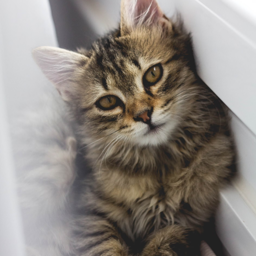

In [8]:
editing_data = image_data[3]
path, source_caption, target_caption = (
    editing_data["path"],
    editing_data["source_caption"],
    editing_data["target_caption"],
)
print(source_caption, target_caption)
image = load_image(path)
image.resize((256, 256))

/data1/junchao/miniconda3/envs/tian/lib/python3.11/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `prediction_type` directly via 'PNDMScheduler' object attribute is deprecated. Please access 'prediction_type' over 'PNDMScheduler's config object instead, e.g. 'scheduler.config.prediction_type'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 200/200 [00:08<00:00, 23.85it/s]


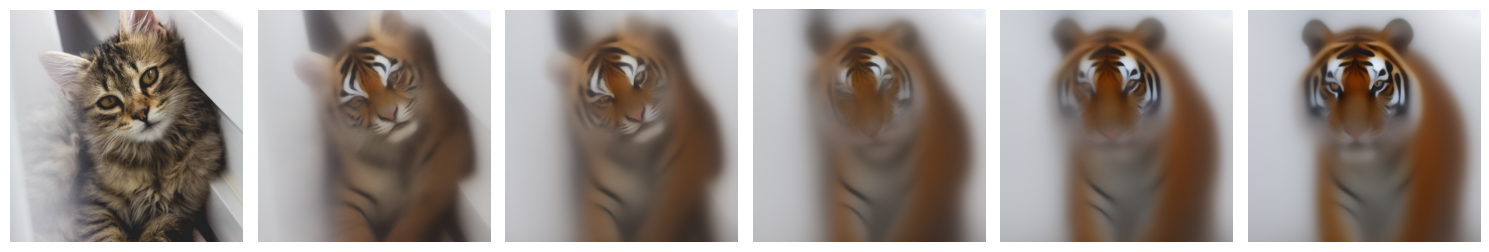

In [9]:
image_optimization(pipeline, image, source_caption, target_caption, use_dds=False)

100%|██████████| 200/200 [00:11<00:00, 17.67it/s]


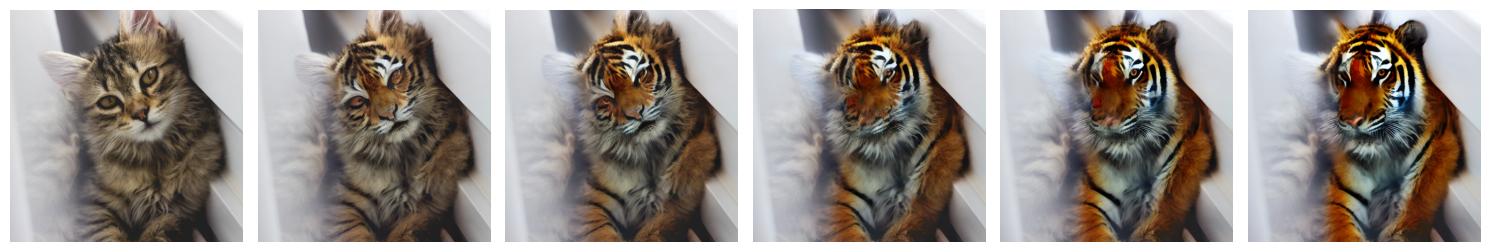

In [10]:
image_optimization(pipeline, image, source_caption, target_caption, use_dds=True)